In [1]:
import os
import pandas as pd
from collections import defaultdict
import numpy as np
from scipy import stats
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
month="02"
coverage_threshold = 0.40

subtype_year2result = dict()

for subtype in ("h3n2", "h1n1"):
    year2result = dict()
    for year in range(2012, 2021):
        vaccine_scores_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=who___virus_set=%d-%s-%d-%s/vaccine_scores" % (year, month, subtype, year-3, month, year, month)
        if not os.path.exists(vaccine_scores_path):
            continue
        for file in os.listdir(vaccine_scores_path):
            if file == "prob=weight_loss_by_count_lightning_logs_version_0___hi=max_steps_150k":
                if os.path.exists(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv")):
                    our_model = (pd.read_csv(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv")))
                    year2result[year] = our_model

    subtype_year2result[subtype] = year2result

In [3]:
subtype_time2vaccine_strains = dict()
subtype_time2ve = dict()
for subtype in ("h3n2", "h1n1"):
    ve_path = "../../data/vaccine_effectiveness/ve_%s.csv" % subtype
    ve = pd.read_csv(ve_path)
    print(ve)
    ve["time_bin"] = [int(year.split("-")[0]) - 2018 + 30 for year in ve["Year"]]
    ve["vaccine effectiveness"] = [x if isinstance(x, float) else float(x[:-1]) for x in ve["VE"].to_numpy()]
    ve["subtype"] = [subtype] * len(ve)
#     print(ve)

    time2vaccine_strains = dict()
    time2ve = dict()

    for strains, year, eff in zip(ve["Strain"], ve["Year"], ve["vaccine effectiveness"]):
        year = int(year.split("-")[0]) # 2018
        time2vaccine_strains[year] = strains.split("|")
        time2ve[year] = eff
    subtype_time2vaccine_strains[subtype] = time2vaccine_strains
    subtype_time2ve[subtype] = time2ve

         Year   VE   95% CI                                     Strain
0   2011-2012  39%  (23 52)                            A/Perth/16/2009
1   2012-2013  39%  (29 47)                        A/Victoria/361/2011
2   2013-2014  NaN      NaN                            A/Texas/50/2012
3   2014-2015   6%  (-5 17)                            A/Texas/50/2012
4   2015-2016  NaN      NaN                 A/Switzerland/9715293/2013
5   2016-2017  33%  (23 41)                      A/Hong Kong/4801/2014
6   2017-2018  22%  (12 31)                      A/Hong Kong/4801/2014
7   2018-2019   9%  (-4 20)            A/Singapore/INFIMH-16-0019/2016
8   2019-2020  NaN      NaN                           A/Kansas/14/2017
9   2020-2021  NaN      NaN  A/Hong Kong/2671/2019|A/Hong Kong/45/2019
10  2021-2022  36%  (21 48)                   A/Cambodia/e0826360/2020
11  2022-2023  45%  (29 58)            A/Darwin/9/2021|A/Darwin/6/2021
         Year   VE   95% CI                                            Strain

In [4]:

ref_vaccine_scores = []
ref_ve = []
ref_source = []
ref_subtype = []

for subtype in ("h3n2", "h1n1"):
    
    year2result = subtype_year2result[subtype]
    time2vaccine_strains = subtype_time2vaccine_strains[subtype]
    time2ve = subtype_time2ve[subtype]

    for year in time2vaccine_strains:
        if year not in year2result:
            continue
        vaccine_strains = time2vaccine_strains[year]
        effectiveness = time2ve[year]
        if isinstance(effectiveness, float) and not np.isnan(effectiveness):
            ref_vaccine_score_pred = []
            ref_vaccine_score_gt = []
            for gt_score, score, name, coverage in zip(year2result[year]["gt_score_seq"], year2result[year]["score"], year2result[year]["strain_name"], year2result[year]["coverage_seq"]):
                if coverage < coverage_threshold:
                    continue
                if not isinstance(name, str):
                    continue
                for vaccine_strain in vaccine_strains:
                    if vaccine_strain.replace(" ", "_") in name:
                        ref_vaccine_score_pred.append(score)
                        ref_vaccine_score_gt.append(gt_score)
                        break

            if len(ref_vaccine_score_pred) > 0:
                ref_vaccine_score = [x  for x in ref_vaccine_score_pred if not np.isnan(x)]
                if len(ref_vaccine_score) > 0:
                    ref_vaccine_scores.append(np.median(ref_vaccine_score_pred))
                    ref_ve.append(effectiveness)
                    ref_source.append("Prediction")
                    ref_subtype.append(subtype)

                ref_vaccine_score_gt = [x  for x in ref_vaccine_score_gt if not np.isnan(x)]
                if len(ref_vaccine_score_gt) > 0:
#                     ref_vaccine_scores.append(sum(ref_vaccine_score_gt) / len(ref_vaccine_score_gt))
                    ref_vaccine_scores.append(np.median(ref_vaccine_score_gt))
                    ref_ve.append(effectiveness)
                    ref_source.append("Ground truth")
                    ref_subtype.append(subtype)


0.9757575757575757 1.4675461874042197e-06
0.8909090909090909 0.0005421442248338665


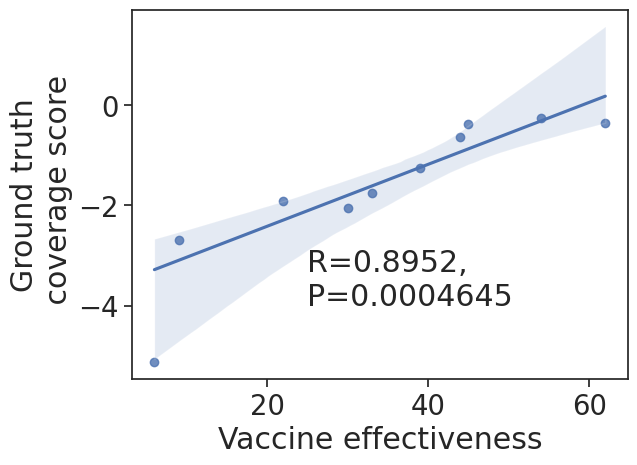

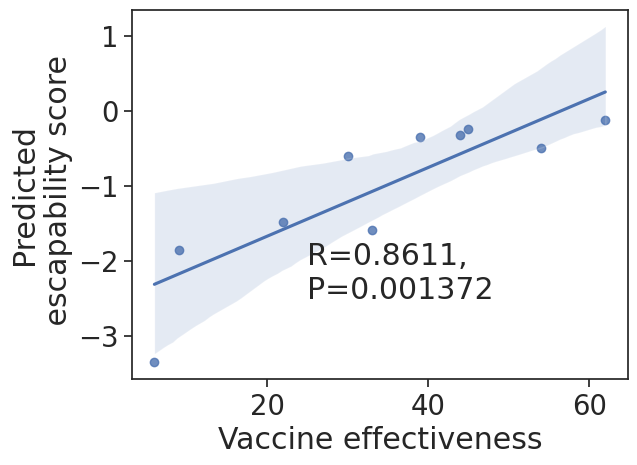

In [5]:


ref_vaccine_scores = np.asarray(ref_vaccine_scores)

d = {'vaccine effectiveness': ref_ve, 
     'escapability score': - ref_vaccine_scores, 
     'subtype': ["A/%s" % x.upper() for x in ref_subtype], '': ref_source}
res = pd.DataFrame(data=d)

# print(res)

sns.set(font_scale=1.8, style="ticks")

gt_spearman_rank, gt_pvalue = stats.spearmanr(res[res[""] == "Ground truth"]["escapability score"], res[res[""] == "Ground truth"]["vaccine effectiveness"])
gt_pearsonr, gt_pvalue_pearson = stats.pearsonr(res[res[""] == "Ground truth"]["escapability score"], res[res[""] == "Ground truth"]["vaccine effectiveness"])


print(gt_spearman_rank, gt_pvalue)

pred_spearman_rank, pred_pvalue = stats.spearmanr(res[res[""] == "Prediction"]["escapability score"], res[res[""] == "Prediction"]["vaccine effectiveness"])
pred_pearsonr, pred_pvalue_pearson = stats.pearsonr(res[res[""] == "Prediction"]["escapability score"], res[res[""] == "Prediction"]["vaccine effectiveness"])


print(pred_spearman_rank, pred_pvalue)

# Ground-truth score & VE
ax = sns.regplot(y = "escapability score", x = "vaccine effectiveness",# , "x"
           data = res[res[""] == "Ground truth"], robust=True, ci=95) # ci = 95) # , ci=95
ax.text(25, -4.0, "R=%.4lf, \nP=%.4g" % (gt_pearsonr, gt_pvalue_pearson))
ax.set_ylabel("Ground truth\n coverage score")
ax.set_xlabel("Vaccine effectiveness")

# print(ax.get_lines()[0].get_ydata())
# print(ax.get_lines()[0].get_xdata())

gt_fitline_ys = ax.get_lines()[0].get_ydata()
gt_fitline_xs = ax.get_lines()[0].get_xdata()

# plt.savefig("figs/ve_%s_gt.pdf" % subtype, format='pdf', bbox_inches='tight')
plt.show()


# Predicted scores & VE
ax = sns.regplot(y = "escapability score", x = "vaccine effectiveness",# , "x"
           data = res[res[""] == "Prediction"], robust=True, ci=95) # ci = 95) # , ci=95
ax.text(25, -2.5, "R=%.4lf, \nP=%.4g" % (pred_pearsonr, pred_pvalue_pearson))

ax.set_ylabel("Predicted\n escapability score")
ax.set_xlabel("Vaccine effectiveness")

pred_fitline_ys = ax.get_lines()[0].get_ydata()
pred_fitline_xs = ax.get_lines()[0].get_xdata()

# plt.savefig("figs/ve_%s_predicted.pdf" % subtype, format='pdf', bbox_inches='tight')
plt.show()

0.06182046426579869
0.04574828642825973


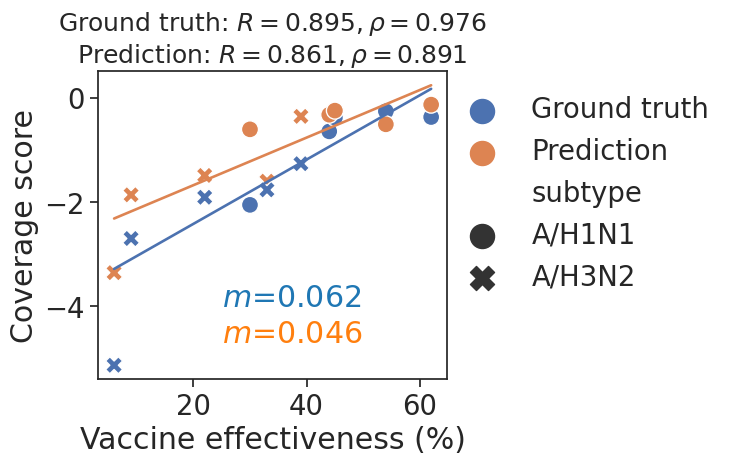

In [6]:

# combine

res = res.sort_values(by=[''])
res = res.sort_values(by=['subtype'])

fig, ax = plt.subplots(figsize=(4.5, 4))

ax = sns.scatterplot(y = "escapability score", x = "vaccine effectiveness",# , "x"
           data = res, hue="", style="subtype", s=150, ax=ax) # ci = 95) # , ci=95


ax = sns.lineplot(y = gt_fitline_ys, x = gt_fitline_xs,linewidth=1.9) # ci = 95) # , ci=95
ax = sns.lineplot(y = pred_fitline_ys, x = pred_fitline_xs,linewidth=1.9) # ci = 95) # , ci=95

print(((gt_fitline_ys[1:] - gt_fitline_ys[:-1]) / (gt_fitline_xs[1:] - gt_fitline_xs[:-1]))[0])
print(((pred_fitline_ys[1:] - pred_fitline_ys[:-1]) / (pred_fitline_xs[1:] - pred_fitline_xs[:-1]))[0])

slope_gt = ((gt_fitline_ys[1:] - gt_fitline_ys[:-1]) / (gt_fitline_xs[1:] - gt_fitline_xs[:-1]))[0]
slope_pred = ((pred_fitline_ys[1:] - pred_fitline_ys[:-1]) / (pred_fitline_xs[1:] - pred_fitline_xs[:-1]))[0]
ax.text(25,-4.7, "$m$=%.3lf" % (slope_pred), color="#ff7f0e")
ax.text(25,-4.0, "$m$=%.3lf" % (slope_gt), color="#1f77b4")

ax.legend(frameon=False)

legend = ax.get_legend()

# Change the size of markers in the legend
for handle in legend.legendHandles:
    handle.set_sizes([300])  # Set size to desired value
    
# ax.set_title(f"Ground truth: $R=%.4lf$\nPrediction: $R=%.4lf$" % (gt_pearsonr, pred_pearsonr))
ax.set_title(f"Ground truth: $R=%.3lf,\\rho=%.3lf$\nPrediction: $R=%.3lf,\\rho=%.3lf$" % (gt_pearsonr, gt_spearman_rank, pred_pearsonr, pred_spearman_rank), fontsize=18)

ax.set_ylabel("Coverage score")
ax.set_xlabel("Vaccine effectiveness (%)")

# plt.legend(labelspacing = 0.1) 

# plt.legend(handletextpad=0.1)  # Adjust handletextpad to decrease/increase the space
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.95, 1))



plt.savefig("figs/ve_overall_new.pdf", format='pdf', bbox_inches='tight')
plt.show()